In [1]:
# Jupyter Notebook

# Packages for Data Visualization and Plotting
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pylab as pylab
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
%matplotlib inline
import matplotlib as mpl

# Packages for Data Analysis and Statistics
import scipy as scipy
from scipy import optimize
from statistics import mean
import numpy as np
import scipy.stats as stats

# Packages for File Handling and Data Import
from os.path import exists
import csv
import protfasta
import os
import glob

# Molecular Dynamics and Trajectory Analysis
from soursop.sstrajectory import SSTrajectory
import mdtraj as md

# Miscellaneous Packages
from statannot import add_stat_annotation
from sparrow import Protein
from sparrow.patterning import iwd

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['legend.fontsize'] = 6

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely aesthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
pd.set_option('precision', 9)

path = r'./Analysis/Data_Charge/' # use your path
all_files = glob.glob(os.path.join(path , "*Ka.csv"))

Total = []

df = pd.concat((pd.read_csv(f) for f in all_files), axis = 1)

df = df.reindex(sorted(df.columns), axis=1)

df

,SCRAMBLE_NTD_Ka,SCRAMBLE_RBD_Ka,SCRAMBLE_WT_Ka,Scramble_0_Ka,Scramble_100_Ka,Scramble_101_Ka,Scramble_102_Ka,Scramble_103_Ka,Scramble_104_Ka,Scramble_105_Ka,...,Scramble_91_Ka,Scramble_92_Ka,Scramble_93_Ka,Scramble_94_Ka,Scramble_95_Ka,Scramble_96_Ka,Scramble_97_Ka,Scramble_98_Ka,Scramble_99_Ka,Scramble_9_Ka
0,0.000002216,0.000004065,0.000384865,0.000022675,0.000113203,0.000662436,0.000006435,0.000241956,0.000016342,0.000273261,...,0.000020484,0.000048176,0.000028081,0.000001797,0.000030637,0.000000892,0.000003143,0.000059570,0.000742721,0.000032737
1,0.000003283,0.000003971,0.000206201,0.001006938,0.000084235,0.013019267,0.000013956,0.000189333,0.000021089,0.000138340,...,0.000011454,0.000026973,0.005434081,0.000005329,0.000020636,0.000001805,0.000004332,0.000118444,0.000488688,0.000023044
2,0.000003119,0.000004190,0.000147671,0.000689512,0.000080634,0.008690368,0.000013099,0.000138106,0.000017859,0.000163556,...,0.000009039,0.000026414,0.003628721,0.000004436,0.000015519,0.000002679,0.000005456,0.000093489,0.000338655,0.000021839
3,0.000002601,0.000004972,0.000111414,0.000564756,0.000062360,0.006542794,0.000015944,0.000105795,0.000014566,0.000126333,...,0.000007573,0.000021945,0.002735608,0.000004350,0.000021548,0.000005661,0.000004859,0.000085850,0.000259720,0.000020314
4,0.000002864,0.000005236,0.000313452,0.000465559,0.000053644,0.017839647,0.000016333,0.000090252,0.000011940,0.000210455,...,0.000011062,0.000035037,0.002190480,0.000004547,0.000031367,0.000010689,0.000004698,0.000070978,0.000246238,0.000017419


In [3]:
#flipping notebook for easier use

df_melted = pd.melt(df)
#df_melted.head(10)
df_structured = df_melted.join(df_melted['variable'].str.split('_', 3, expand=True).rename(columns={0:'NTD', 1:'Replicate', 2:'Measurement'}))
df_structured = df_structured.rename(columns = {"Ka": "Blank", "value": "Ka"})
print(df_structured)

             variable           Ka       NTD Replicate Measurement
0     SCRAMBLE_NTD_Ka  0.000002216  SCRAMBLE       NTD          Ka
1     SCRAMBLE_NTD_Ka  0.000003283  SCRAMBLE       NTD          Ka
2     SCRAMBLE_NTD_Ka  0.000003119  SCRAMBLE       NTD          Ka
3     SCRAMBLE_NTD_Ka  0.000002601  SCRAMBLE       NTD          Ka
4     SCRAMBLE_NTD_Ka  0.000002864  SCRAMBLE       NTD          Ka
...               ...          ...       ...       ...         ...
1910    Scramble_9_Ka  0.000032737  Scramble         9          Ka
1911    Scramble_9_Ka  0.000023044  Scramble         9          Ka
1912    Scramble_9_Ka  0.000021839  Scramble         9          Ka
1913    Scramble_9_Ka  0.000020314  Scramble         9          Ka
1914    Scramble_9_Ka  0.000017419  Scramble         9          Ka

[1915 rows x 5 columns]


In [4]:
#generating df so that we can merge sequence data with binding data

output_file = "consolidated.csv"  # Path to the output consolidated CSV file
directory = r'./Analysis/Sequences/'  # Directory where the individual CSV files are located

data = []  # List to store the data from individual CSV files

# Read data from individual CSV files
for filename in os.listdir(directory):
    if filename.endswith(".csv") and filename.startswith("Scramble_"):
        csv_file = os.path.join(directory, filename)
        with open(csv_file, 'r') as csv_in:
            reader = csv.reader(csv_in)
            row = next(reader)  # Get the first (and only) row from the individual CSV
            data.append([filename, row[0]])  # Store the filename and the string in the data list

# Sort data based on column 1 (filename) in alphanumeric order
sorted_data = sorted(data, key=lambda x: x[0])

# Write data to the consolidated CSV file
with open(output_file, 'w', newline='') as csv_out:
    writer = csv.writer(csv_out)
    writer.writerow(["Filename", "String"])  # Write the header row

    for row in sorted_data:
        writer.writerow(row)

print("Consolidated CSV file has been created successfully.")

Consolidated CSV file has been created successfully.


In [5]:
# Read the CSV file into a DataFrame used to merge sequences with Binding Data
dfc = pd.read_csv('./consolidated.csv')

In [6]:
# Specify the part of the string you want to remove, need to remove csv from names
part_to_remove = ".csv"

# Loop through each column in the DataFrame and apply string replacement
for column in dfc.columns:
    dfc['Filename'] = dfc['Filename'].str.replace(part_to_remove, "")
    
# Specify the part of the string you want to remove
part_to_remove = "Scramble_"

# Loop through each column in the DataFrame and apply string replacement
for column in dfc.columns:
    dfc['Filename'] = dfc['Filename'].str.replace(part_to_remove, "")

    # Rename the column
dfc.rename(columns={'Filename': 'Replicate'}, inplace=True)

# Print the modified DataFrame
dfc


,Replicate,String
0,0,SRGTSQGPNPDQKPIQQGSSGFNENRDPSMGTRAQGANNPRSNRRG...
1,1,TRGGNLRQNNGTQSFAENTPPQIPDSGGGRNPKQDMGSSSAPRRNQ...
2,10,GPSGSGAGNNPSSQQRRSTQGRPNRDFTTMNNANQQIRRPGEPSLD...
3,100,SPGQSSQTNKSRGGNGLGTNDPNPGFTARRRSRPRQPEDQNAGMNS...
4,101,DGIFQGSNPGRGLQPSQGNGESNDAQNTKSSTARPQTGMSNPRRNN...
...,...,...
384,98,NDDNSTPGPGPRENFTGSTNIRNQKRGGNQSQGAPRQRGPANSSQL...
385,99,STGEKRTSSGLIGDQGQSNGQGPMRPNGNNSQATPQRANNNPDPRS...
386,NTD,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT
387,RBD,ASWFTALTQHGKEDLKFPRGQGVPINTNSSPDDQIGYYRRATRRIR...


In [7]:
# Read the CSV file into a DataFrame
df_pattern = pd.read_csv('./consolidated.csv')

df_pattern

,Filename,String
0,Scramble_0.csv,SRGTSQGPNPDQKPIQQGSSGFNENRDPSMGTRAQGANNPRSNRRG...
1,Scramble_1.csv,TRGGNLRQNNGTQSFAENTPPQIPDSGGGRNPKQDMGSSSAPRRNQ...
2,Scramble_10.csv,GPSGSGAGNNPSSQQRRSTQGRPNRDFTTMNNANQQIRRPGEPSLD...
3,Scramble_100.csv,SPGQSSQTNKSRGGNGLGTNDPNPGFTARRRSRPRQPEDQNAGMNS...
4,Scramble_101.csv,DGIFQGSNPGRGLQPSQGNGESNDAQNTKSSTARPQTGMSNPRRNN...
...,...,...
384,Scramble_98.csv,NDDNSTPGPGPRENFTGSTNIRNQKRGGNQSQGAPRQRGPANSSQL...
385,Scramble_99.csv,STGEKRTSSGLIGDQGQSNGQGPMRPNGNNSQATPQRANNNPDPRS...
386,Scramble_NTD.csv,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT
387,Scramble_RBD.csv,ASWFTALTQHGKEDLKFPRGQGVPINTNSSPDDQIGYYRRATRRIR...


In [8]:
with open('output.fasta', 'w') as f:
    for index, row in df_pattern.iterrows():
        # Remove "Scramble_" and ".csv" from the first column
        column1_text = row['Filename'].replace('Scramble_', '').replace('.csv', '')
        
        # Write the formatted string to the file
        f.write(f'>{column1_text}\n{row["String"]}\n')

In [9]:
#prep for getting charge information about equences
current_filepath = os.getcwd()
all_seqs = "{}/output.fasta".format(current_filepath)
seqs = protfasta.read_fasta(all_seqs)

In [10]:
Pos_Weighted = []
Neg_Weighted = []
Biv_Weighted = []

for k in seqs:
    
    local_seq = seqs[k]
    
    patterning = Protein(local_seq).compute_iwd_charged_weighted('+')
    
    Pos_Weighted.append(patterning)
    
    patterning = Protein(local_seq).compute_iwd_charged_weighted('-')
    
    Neg_Weighted.append(patterning)
    
    patterning = Protein(local_seq).compute_bivariate_iwd_charged_weighted()
    
    Biv_Weighted.append(patterning)
    
    
    
    
#print(Pos_Weighted)

df_pattern = pd.DataFrame(seqs.items(), columns=['Replicate', 'String'])

df_pattern['IWD+'] = Pos_Weighted

df_pattern['IWD-'] = Neg_Weighted

df_pattern['IWDBIV'] = Biv_Weighted

df_pattern

,Replicate,String,IWD+,IWD-,IWDBIV
0,0,SRGTSQGPNPDQKPIQQGSSGFNENRDPSMGTRAQGANNPRSNRRG...,0.202921738,0.033587073,0.050374098
1,1,TRGGNLRQNNGTQSFAENTPPQIPDSGGGRNPKQDMGSSSAPRRNQ...,0.188768529,0.016898148,0.055007867
2,10,GPSGSGAGNNPSSQQRRSTQGRPNRDFTTMNNANQQIRRPGEPSLD...,0.216693835,0.012500000,0.059157824
3,100,SPGQSSQTNKSRGGNGLGTNDPNPGFTARRRSRPRQPEDQNAGMNS...,0.710661432,0.092864924,0.132840931
4,101,DGIFQGSNPGRGLQPSQGNGESNDAQNTKSSTARPQTGMSNPRRNN...,0.335300770,0.067240338,0.056894344
...,...,...,...,...,...
384,98,NDDNSTPGPGPRENFTGSTNIRNQKRGGNQSQGAPRQRGPANSSQL...,0.268971668,0.182575758,0.039972458
385,99,STGEKRTSSGLIGDQGQSNGQGPMRPNGNNSQATPQRANNNPDPRS...,0.174241702,0.005603448,0.052257154
386,NTD,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,0.436807904,0.010503690,0.061333951
387,RBD,ASWFTALTQHGKEDLKFPRGQGVPINTNSSPDDQIGYYRRATRRIR...,0.501290814,0.116607112,0.118366939


In [11]:
# Perform the merge based on the matching integer column
merged_df = pd.merge(df_structured, dfc, on='Replicate')

# Rename the string column from df1
merged_df.rename(columns={'String': 'Sequences'}, inplace=True)

# Print the merged dataframe
merged_df

,variable,Ka,NTD,Replicate,Measurement,Sequences
0,SCRAMBLE_NTD_Ka,0.000002216,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT
1,SCRAMBLE_NTD_Ka,0.000003283,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT
2,SCRAMBLE_NTD_Ka,0.000003119,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT
3,SCRAMBLE_NTD_Ka,0.000002601,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT
4,SCRAMBLE_NTD_Ka,0.000002864,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT
...,...,...,...,...,...,...
1910,Scramble_9_Ka,0.000032737,Scramble,9,Ka,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...
1911,Scramble_9_Ka,0.000023044,Scramble,9,Ka,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...
1912,Scramble_9_Ka,0.000021839,Scramble,9,Ka,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...
1913,Scramble_9_Ka,0.000020314,Scramble,9,Ka,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...


In [12]:
# Perform the merge based on the matching integer column
merged_df = pd.merge(merged_df, df_pattern, on='Replicate')


In [13]:
#generate a list of all seqs to assess
Sequences = []

Sequences.append('WT')
Sequences.append('NTD')
Sequences.append('RBD')
for i in range(0,173):
    q = ('%i')%i
    Sequences.append(q)
#Sequences

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. RBD: t-test independent samples with Bonferroni correction, P_val=4.209e-03 stat=4.462e+00
WT v.s. NTD: t-test independent samples with Bonferroni correction, P_val=4.030e-03 stat=4.495e+00


(<AxesSubplot:ylabel='Ka*'>,
  <statannot.StatResult.StatResult at 0x7f470059d0a0>])

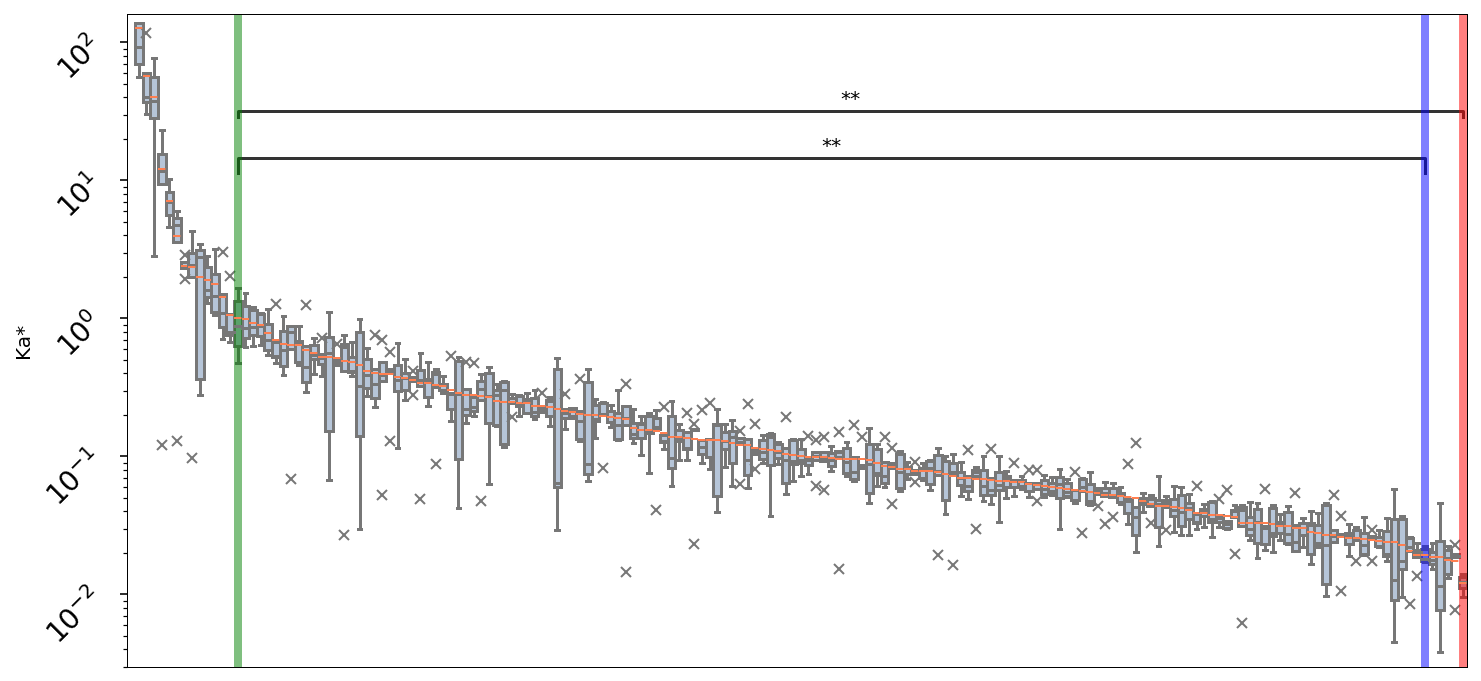

In [14]:
#Plot Highest to Lowest

#Get Wildtype average for KA* calculation
wt_df = merged_df[merged_df['Replicate'] == 'WT']

# Calculate the mean of 'Ka' in 'wt_df'
wt_mean_Ka = wt_df['Ka'].mean()

# Create a list of valid replicate values
valid_replicates = Sequences

# Filter the DataFrame to include only rows with replicate values in the 'valid_replicates' list
filtered_df = merged_df[merged_df['Replicate'].isin(valid_replicates)]

# Normalize the 'Ka' values in 'merged_df' by dividing by 'wt_mean_Ka'
filtered_df['Ka*'] = filtered_df['Ka'] / wt_mean_Ka

wt_df['Ka*'] = wt_df['Ka'] / wt_mean_Ka
from statannot import add_stat_annotation

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.set_yscale('log')


mpl.rcParams['axes.linewidth'] = 3 #set the value globally
# Define the colors for the specific strings

# Define the default color for other values

from scipy.stats import gmean
from scipy.stats import gstd

# Calculate the geometric mean of the 'Ka' column
geometric_mean_ka = gmean(filtered_df['Ka*'])

data = filtered_df['Ka*']
# Calculate the geometric mean of your dataset
geometric_mean = gmean(data)

# Calculate the standard deviation of your dataset
std_dev = gstd(data)

# Calculate the lower and upper bounds
lower_bound = geometric_mean - std_dev
upper_bound = geometric_mean + std_dev

plt.ylim(0.003, 160)

df = filtered_df
x = "Replicate"
y = "Ka*"
order = filtered_df.groupby('Replicate')['Ka*'].agg('mean').sort_values(ascending=False).index
ax = sns.boxplot(data=df, x=x, y=y, order=order, showmeans=True,
                 color = 'lightsteelblue', width = 1, meanline = True,
                 dodge = False, flierprops={"marker": "x"},
                 meanprops={"color": "coral"})

test_results = add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                                   box_pairs=[("WT", "RBD"), ("WT","NTD")],
                                   test='t-test_ind', text_format='star',
                                   verbose=2)


plt.xlabel('Scramble', fontsize=12);
plt.tick_params(axis='both', which='major', labelsize=14, labelrotation = 45, pad = 6)

for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(40)
    
plt.axvline(x = 14, color = 'Green', label = 'WT', lw = 4, alpha = .5)
plt.axvline(x = 170, color = 'Blue', label = 'NTD', lw = 4, alpha = .5)
plt.axvline(x = 175, color = 'Red', label = 'RBD', lw = 4, alpha = .5)

 
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xlabel('')

#ax.get_legend().remove()

#fig.savefig(f'Analysis/Plots/Scramble_box_plot.png', format='png')
#fig.savefig(f'Analysis/Plots/Scramble_box_plot.pdf', format='pdf', dpi = 800)
plt.yscale('log')
test_results

In [15]:
#Function to calculate charge positioninh
def calculate_positional_features(sequence):

    charged_residues = ['R', 'K']

    # Find the positions of all charged residues
    charged_positions = [i for i, residue in enumerate(sequence) if residue in charged_residues]

    if charged_positions:
        first_position = charged_positions[0]
        last_position = charged_positions[-1]
        avg_position = np.mean(charged_positions)
    else:
        first_position = np.nan
        last_position = np.nan
        avg_position = np.nan

    return pd.Series([first_position, last_position, avg_position], index=['First_Position', 'Last_Position', 'Avg_Position'])

In [16]:
#generate df of chareg positioning
merged_df[['First_Position', 'Last_Position', 'Avg_Position']] = merged_df['Sequences'].apply(calculate_positional_features)

In [17]:
#visualize
merged_df

,variable,Ka,NTD,Replicate,Measurement,Sequences,String,IWD+,IWD-,IWDBIV,First_Position,Last_Position,Avg_Position
0,SCRAMBLE_NTD_Ka,0.000002216,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,0.436807904,0.01050369,0.061333951,9.0,40.0,29.142857143
1,SCRAMBLE_NTD_Ka,0.000003283,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,0.436807904,0.01050369,0.061333951,9.0,40.0,29.142857143
2,SCRAMBLE_NTD_Ka,0.000003119,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,0.436807904,0.01050369,0.061333951,9.0,40.0,29.142857143
3,SCRAMBLE_NTD_Ka,0.000002601,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,0.436807904,0.01050369,0.061333951,9.0,40.0,29.142857143
4,SCRAMBLE_NTD_Ka,0.000002864,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,0.436807904,0.01050369,0.061333951,9.0,40.0,29.142857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,Scramble_9_Ka,0.000032737,Scramble,9,Ka,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,0.239380115,0.00687500,0.053913648,6.0,47.0,19.857142857
1911,Scramble_9_Ka,0.000023044,Scramble,9,Ka,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,0.239380115,0.00687500,0.053913648,6.0,47.0,19.857142857
1912,Scramble_9_Ka,0.000021839,Scramble,9,Ka,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,0.239380115,0.00687500,0.053913648,6.0,47.0,19.857142857
1913,Scramble_9_Ka,0.000020314,Scramble,9,Ka,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,0.239380115,0.00687500,0.053913648,6.0,47.0,19.857142857


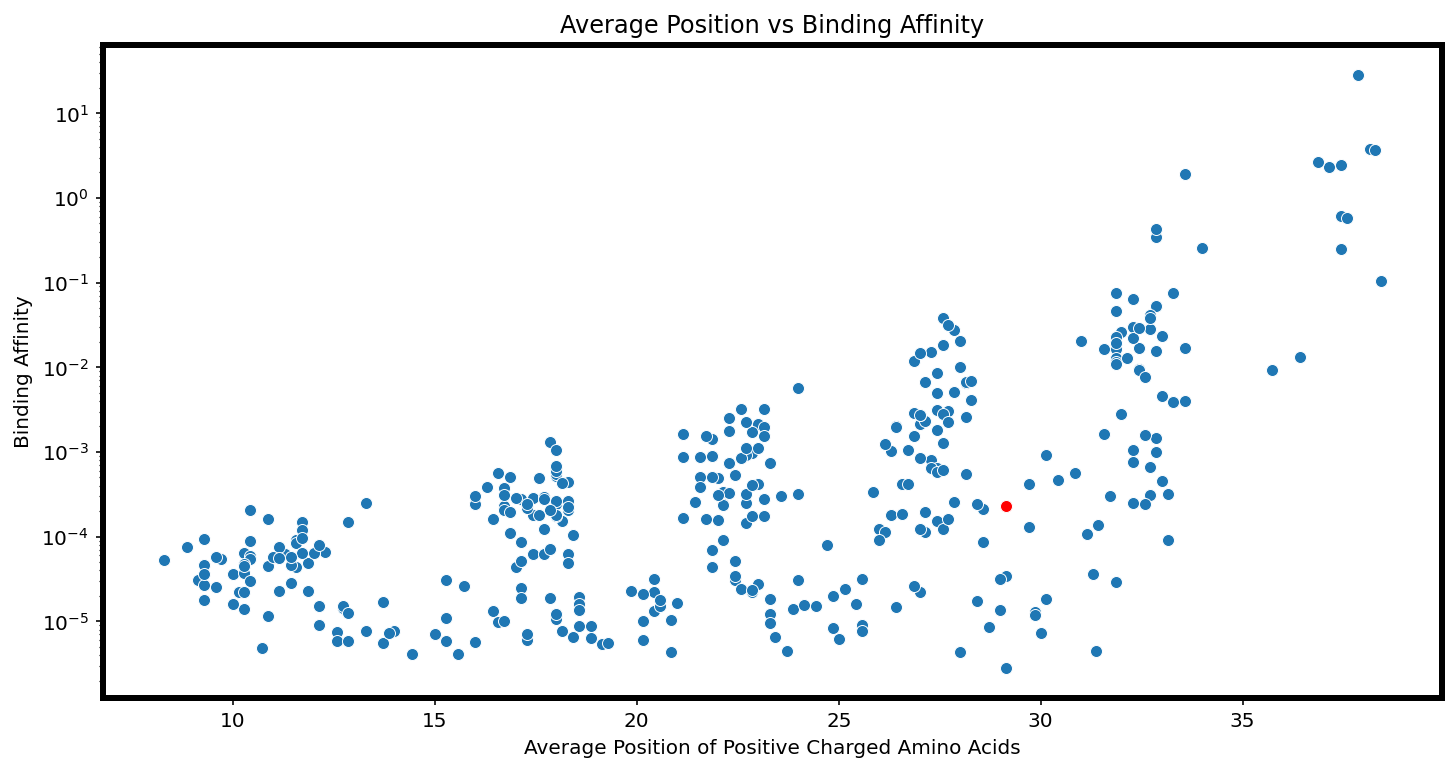

In [18]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

# Plot tall points scatter plot using the filtered dataframe

sns.scatterplot(data = merged_df, x = merged_df.groupby('Replicate')['Avg_Position'].mean(), y = merged_df.groupby('Replicate')['Ka'].mean())

#Filter the dataframe based on the condition
wt_df = merged_df[merged_df['Replicate'] == 'WT']
#WT is plotted in red
sns.scatterplot(data =wt_df, x = wt_df['Avg_Position'], y = wt_df['Ka'].mean(), color = 'red')

plt.xlabel('Average Position of Positive Charged Amino Acids')
plt.ylabel('Binding Affinity')
plt.title('Average Position vs Binding Affinity')
plt.yscale('log')

plt.legend([],[], frameon=False)

plt.show()


In [19]:
#Generated 100,000 scrambled sequences of the NTD to determine what a 'reasonable' sequence charge patterning is
current_filepath = os.getcwd()
shuffled = "/work/alstonj/2023/Alston_2023/Figure_7/shuffled_sequences100.fasta".format(current_filepath)
seqs = protfasta.read_fasta(shuffled)

In [20]:
#Compute IWDD+ for all seqs
Pos_Weighted_Shuffled = []

for k in seqs:
    
    local_seq = seqs[k]
    
    patterning = Protein(local_seq).compute_iwd_charged_weighted('+')
    
    Pos_Weighted_Shuffled.append(patterning)
    
    
#print(Pos_Weighted)

df_shuffled = pd.DataFrame(seqs.items(), columns=['Replicate', 'String'])

df_shuffled['IWD+'] = Pos_Weighted_Shuffled

df_shuffled

,Replicate,String,IWD+
0,1\,QGAQDRMGPNPPFQRTPRGASNKREQPRDNGSGRNQNGTSISSNSGLNT,0.131756690
1,2\,QSTNQNISSEPANNNTGDGGRGQRSRFRGLRPGDPNSTQPAKMRSQGPN,0.339895173
2,3\,NNRMQGRSSIQDGTQNGAEPPFGRPPRTANTGKQRSQRSLDSSGNGNPN,0.197165403
3,4\,GSGNAFMKSNDQPGIGDGSRPSNQQRPNRTRNPTSSRNGQLTENRAGQP,0.144334467
4,5\,QTSPANGPIGGRQTPATERGSSNGLSFQRSDQGNRRGKNNPDMQRNNPS,0.229751896
...,...,...,...
99995,99996\,SNSSTDNQAQGGQNIQRTNGPSGPAPNRTQRGDRSKFPNRLNGSGREPM,0.174658687
99996,99997\,EQKRSRDANRGNSPSNQGTSPPTSGRQNPRGNFNGTARNGDLPQQMSGI,0.144725115
99997,99998\,PMNPGNSQGSPDTTQRRNTENGQSNRPGNRQGNDFASKRSGGRPAQLIS,0.189245745
99998,99999\,QPDRIGSSGNPQLGTGENTRAGDTGQPNQNRSSFNSNMNSPRRGPRKQA,0.392934421


In [21]:
#Calculate their binning

def calculate_positional_features(sequence):
    charged_residues = ['R', 'K']  # List of charged residues

    # Find the positions of all charged residues
    charged_positions = [i for i, residue in enumerate(sequence) if residue in charged_residues]

    if charged_positions:
        first_position = charged_positions[0]
        last_position = charged_positions[-1]
        avg_position = np.mean(charged_positions)
    else:
        first_position = np.nan
        last_position = np.nan
        avg_position = np.nan

    return pd.Series([first_position, last_position, avg_position], index=['First_Position', 'Last_Position', 'Avg_Position'])

# Calculate the 'Avg_Position' column
df_shuffled[['First_Position', 'Last_Position', 'Avg_Position']] = df_shuffled['String'].apply(calculate_positional_features)

# Define the bin boundaries
bin_boundaries = np.arange(0, 50, 5)

# Add the 'Bin' column to df_shuffled
df_shuffled['Bin'] = np.nan

# Iterate over each row in the dataframe
for index, row in df_shuffled.iterrows():
    # Check if the 'Avg_Position' value falls within any bin
    for i, boundary in enumerate(bin_boundaries):
        if boundary <= row['Avg_Position'] < boundary + 5:
            # Calculate the midpoint of the bin
            bin_midpoint = boundary + 2.5
            
            # Assign the bin midpoint to the 'Bin' column
            df_shuffled.loc[index, 'Bin'] = bin_midpoint
            break

            
df_shuffled

,Replicate,String,IWD+,First_Position,Last_Position,Avg_Position,Bin
0,1\,QGAQDRMGPNPPFQRTPRGASNKREQPRDNGSGRNQNGTSISSNSGLNT,0.131756690,5.0,33.0,20.142857143,22.5
1,2\,QSTNQNISSEPANNNTGDGGRGQRSRFRGLRPGDPNSTQPAKMRSQGPN,0.339895173,20.0,43.0,29.857142857,27.5
2,3\,NNRMQGRSSIQDGTQNGAEPPFGRPPRTANTGKQRSQRSLDSSGNGNPN,0.197165403,2.0,37.0,22.857142857,22.5
3,4\,GSGNAFMKSNDQPGIGDGSRPSNQQRPNRTRNPTSSRNGQLTENRAGQP,0.144334467,7.0,44.0,27.000000000,27.5
4,5\,QTSPANGPIGGRQTPATERGSSNGLSFQRSDQGNRRGKNNPDMQRNNPS,0.229751896,11.0,44.0,29.571428571,27.5
...,...,...,...,...,...,...,...
99995,99996\,SNSSTDNQAQGGQNIQRTNGPSGPAPNRTQRGDRSKFPNRLNGSGREPM,0.174658687,16.0,45.0,32.142857143,32.5
99996,99997\,EQKRSRDANRGNSPSNQGTSPPTSGRQNPRGNFNGTARNGDLPQQMSGI,0.144725115,2.0,37.0,15.714285714,17.5
99997,99998\,PMNPGNSQGSPDTTQRRNTENGQSNRPGNRQGNDFASKRSGGRPAQLIS,0.189245745,15.0,42.0,28.857142857,27.5
99998,99999\,QPDRIGSSGNPQLGTGENTRAGDTGQPNQNRSSFNSNMNSPRRGPRKQA,0.392934421,3.0,46.0,32.285714286,32.5


In [22]:
# recategorize bins
df_shuffled['Bin'] = df_shuffled['Bin'].rank(method='dense').astype(int)

df_shuffled


,Replicate,String,IWD+,First_Position,Last_Position,Avg_Position,Bin
0,1\,QGAQDRMGPNPPFQRTPRGASNKREQPRDNGSGRNQNGTSISSNSGLNT,0.131756690,5.0,33.0,20.142857143,4
1,2\,QSTNQNISSEPANNNTGDGGRGQRSRFRGLRPGDPNSTQPAKMRSQGPN,0.339895173,20.0,43.0,29.857142857,5
2,3\,NNRMQGRSSIQDGTQNGAEPPFGRPPRTANTGKQRSQRSLDSSGNGNPN,0.197165403,2.0,37.0,22.857142857,4
3,4\,GSGNAFMKSNDQPGIGDGSRPSNQQRPNRTRNPTSSRNGQLTENRAGQP,0.144334467,7.0,44.0,27.000000000,5
4,5\,QTSPANGPIGGRQTPATERGSSNGLSFQRSDQGNRRGKNNPDMQRNNPS,0.229751896,11.0,44.0,29.571428571,5
...,...,...,...,...,...,...,...
99995,99996\,SNSSTDNQAQGGQNIQRTNGPSGPAPNRTQRGDRSKFPNRLNGSGREPM,0.174658687,16.0,45.0,32.142857143,6
99996,99997\,EQKRSRDANRGNSPSNQGTSPPTSGRQNPRGNFNGTARNGDLPQQMSGI,0.144725115,2.0,37.0,15.714285714,3
99997,99998\,PMNPGNSQGSPDTTQRRNTENGQSNRPGNRQGNDFASKRSGGRPAQLIS,0.189245745,15.0,42.0,28.857142857,5
99998,99999\,QPDRIGSSGNPQLGTGENTRAGDTGQPNQNRSSFNSNMNSPRRGPRKQA,0.392934421,3.0,46.0,32.285714286,6


0.856961729966801
0.8903296279350407
0.9839981117355843
0.9522162859147001
1.1904298326713383
1.1681805808168715
1.3004009300875188
1.2349188788622738
[(0.856961729966801, 1), (0.8903296279350407, 2), (0.9839981117355843, 3), (0.9522162859147001, 4), (1.1904298326713383, 5), (1.1681805808168715, 6), (1.3004009300875188, 7), (1.2349188788622738, 8)]


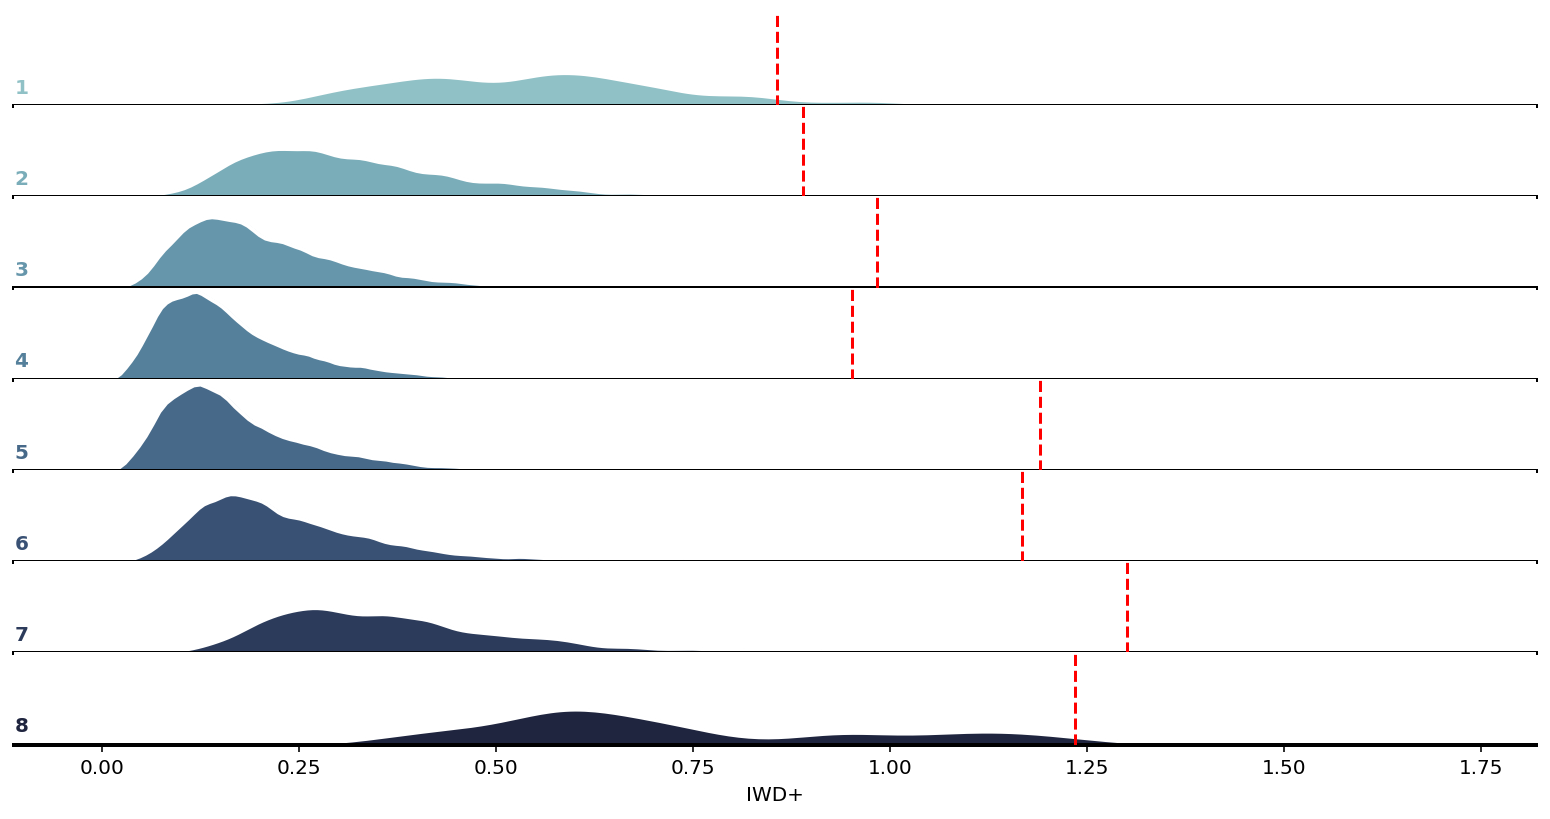

In [23]:
#Determine per bin 99perdcentile cutoffs

# Create the bins
bins = df_shuffled['Bin'].unique()
n_bins = len(bins)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(n_bins, rot=-.25, light=.7)
g = sns.FacetGrid(df_shuffled, row="Bin", hue="Bin", aspect=15, height=.75, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "IWD+", bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "IWD+", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color='k', clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

# Apply the labels based on bins
g.map(label, "IWD+")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.01)

total_threshold = []  # List to store threshold values and corresponding j values

# Add vertical lines at the 99.9 percentile cutoff for each ridge plot
for i, ax_row in enumerate(g.axes):
    for j, ax in enumerate(ax_row):
        bin_value = bins[i]
        bin_data = df_shuffled[df_shuffled['Bin'] == bin_value]
        threshold = np.percentile(bin_data['IWD+'], 99.9)
        print(threshold)
        ax.axvline(threshold, color='red', linestyle='--')
        total_threshold.append((threshold, i+1))

print(total_threshold)
# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Show the plot
plt.show()

In [24]:
# Define the bin boundaries
bin_boundaries = np.arange(0, 50, 5)

# Add the 'Bin' column to df_shuffled
merged_df['Bin'] = np.nan

# Iterate over each row in the dataframe
for index, row in merged_df.iterrows():
    # Check if the 'Avg_Position' value falls within any bin
    for i, boundary in enumerate(bin_boundaries):
        if boundary <= row['Avg_Position'] < boundary + 5:
            # Calculate the midpoint of the bin
            bin_midpoint = boundary + 2.5
            
            # Assign the bin midpoint to the 'Bin' column
            merged_df.loc[index, 'Bin'] = bin_midpoint
            break
            
            # recategorize bins
merged_df['Bin'] = merged_df['Bin'].rank(method='dense').astype(int)

merged_df


,variable,Ka,NTD,Replicate,Measurement,Sequences,String,IWD+,IWD-,IWDBIV,First_Position,Last_Position,Avg_Position,Bin
0,SCRAMBLE_NTD_Ka,0.000002216,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,0.436807904,0.01050369,0.061333951,9.0,40.0,29.142857143,5
1,SCRAMBLE_NTD_Ka,0.000003283,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,0.436807904,0.01050369,0.061333951,9.0,40.0,29.142857143,5
2,SCRAMBLE_NTD_Ka,0.000003119,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,0.436807904,0.01050369,0.061333951,9.0,40.0,29.142857143,5
3,SCRAMBLE_NTD_Ka,0.000002601,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,0.436807904,0.01050369,0.061333951,9.0,40.0,29.142857143,5
4,SCRAMBLE_NTD_Ka,0.000002864,SCRAMBLE,NTD,Ka,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNT,0.436807904,0.01050369,0.061333951,9.0,40.0,29.142857143,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,Scramble_9_Ka,0.000032737,Scramble,9,Ka,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,0.239380115,0.00687500,0.053913648,6.0,47.0,19.857142857,3
1911,Scramble_9_Ka,0.000023044,Scramble,9,Ka,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,0.239380115,0.00687500,0.053913648,6.0,47.0,19.857142857,3
1912,Scramble_9_Ka,0.000021839,Scramble,9,Ka,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,0.239380115,0.00687500,0.053913648,6.0,47.0,19.857142857,3
1913,Scramble_9_Ka,0.000020314,Scramble,9,Ka,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,MNPTNGRRIRPDGNSNPFKASGQRSTNQDRSPGSGNEPSGQNAQTL...,0.239380115,0.00687500,0.053913648,6.0,47.0,19.857142857,3


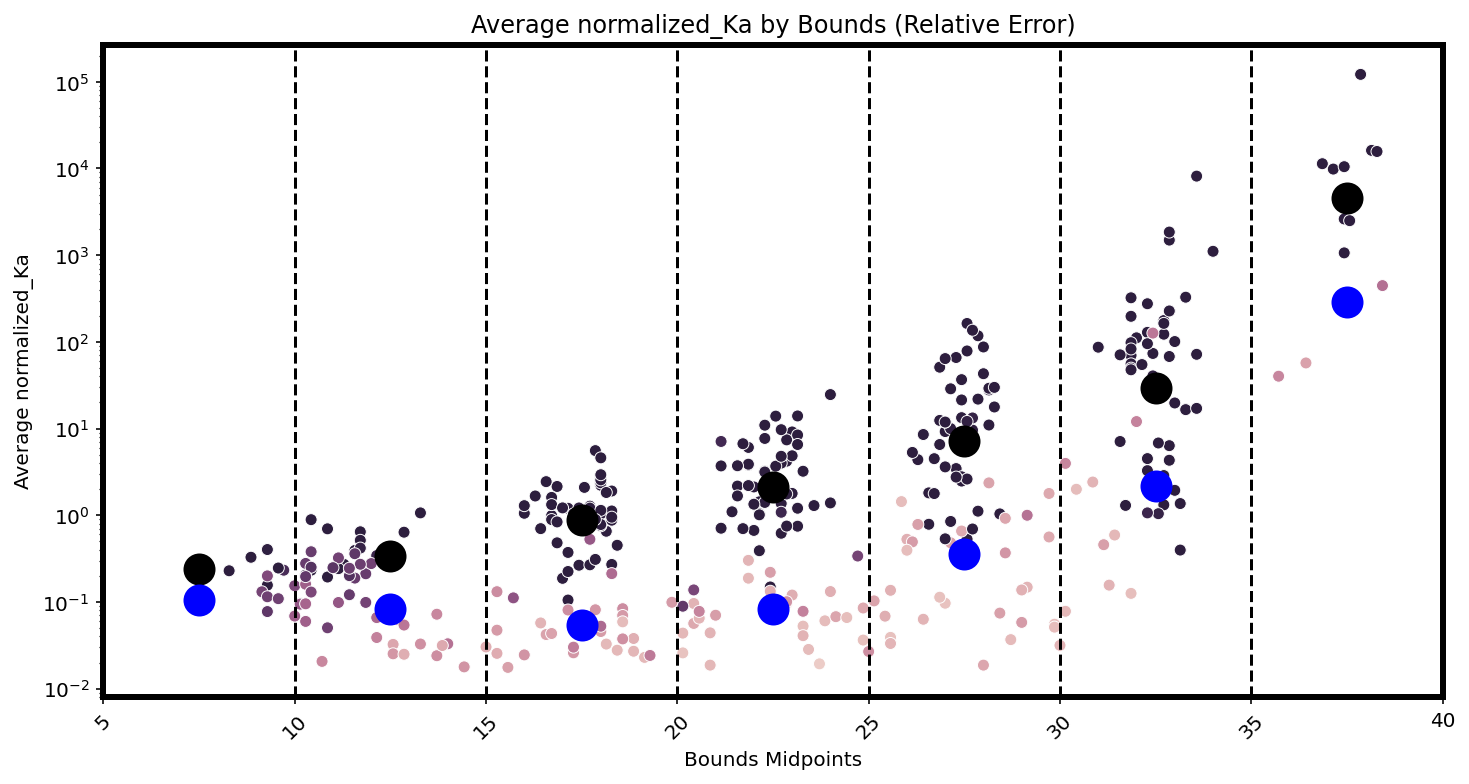

In [25]:
# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Calculate the mean of 'Ka' in 'wt_df'
wt_mean_Ka = wt_df['Ka'].mean()

# Normalize the 'Ka' values in 'merged_df' by dividing by 'wt_mean_Ka'
merged_df['normalized_Ka'] = merged_df['Ka'] / wt_mean_Ka

# Filter the dataframe based on the condition
merged_df = merged_df[~merged_df['Replicate'].str.contains('NTD|RBD')]

df_greater = pd.DataFrame(columns=merged_df.columns)  # DataFrame to store rows with IWD+ greater than threshold
df_lesser = pd.DataFrame(columns=merged_df.columns)  # DataFrame to store rows with IWD+ less than threshold

# Create a dictionary to store the threshold values for each bin
threshold_dict = {j: threshold for threshold, j in total_threshold}
#print(threshold_dict)

# Iterate over each row in the DataFrame
for index, row in merged_df.iterrows():
    bin_value = row['Bin']
    iwd_plus = row['IWD+']
    
    # Get the threshold value for the corresponding bin value from the dictionary
    threshold = threshold_dict.get(bin_value)
    
    # Check if IWD+ is greater than threshold
    if threshold is not None and iwd_plus > threshold:
        df_greater = df_greater.append(row)
        row['Split'] = 1  # Set 'Split' column to 1
    else:
        df_lesser = df_lesser.append(row)
        row['Split'] = 0  # Set 'Split' column to 0

# Reset the index of the resulting DataFrames
df_greater.reset_index(drop=True, inplace=True)
df_lesser.reset_index(drop=True, inplace=True)

#print(df_greater)
#print(df_lesser)

# Plot the scatter plots using the filtered dataframes
sns.scatterplot(data=df_greater, x=df_greater.groupby('Replicate')['Avg_Position'].mean(), y=df_greater.groupby('Replicate')['normalized_Ka'].mean(), hue=df_greater.groupby('Replicate')['IWD+'].mean(), hue_norm=(0, threshold), ax=ax)
sns.scatterplot(data=df_lesser, x=df_lesser.groupby('Replicate')['Avg_Position'].mean(), y=df_lesser.groupby('Replicate')['normalized_Ka'].mean(), hue=df_lesser.groupby('Replicate')['IWD+'].mean(), hue_norm=(0, threshold), ax=ax)

# Define the bin boundaries
bin_boundaries = np.arange(0, 50, 5)

# Calculate the average value and relative error of normalized_Ka for every 3-value bin (for df_greater)
geometric_mean_by_bounds_greater = df_greater.groupby(pd.cut(df_greater['Avg_Position'], bins=bin_boundaries))['normalized_Ka'].apply(gmean)
relative_error_by_bounds_greater = df_greater.groupby(pd.cut(df_greater['Avg_Position'], bins=bin_boundaries)).std()['normalized_Ka']

# Calculate the average value and relative error of normalized_Ka for every 3-value bin (for df_lesser)
geometric_mean_by_bounds_lesser = df_lesser.groupby(pd.cut(df_lesser['Avg_Position'], bins=bin_boundaries))['normalized_Ka'].apply(gmean)
relative_error_by_bounds_lesser = df_lesser.groupby(pd.cut(df_lesser['Avg_Position'], bins=bin_boundaries)).std()['normalized_Ka']

# Calculate the midpoints of the bins
bounds_midpoints = [(bin_boundary.left + bin_boundary.right) / 2 for bin_boundary in geometric_mean_by_bounds_lesser.index]

# Create an empty DataFrame to store the results
data_greater = pd.DataFrame(columns=['Avg_Position', 'Mean', 'Bin'])
data_lesser = pd.DataFrame(columns=['Avg_Position', 'Mean', 'Bin'])

# Iterate over each row in the dataframe (for df_greater)
for index, row in df_greater.iterrows():
    # Check if the 'Avg_Position' value falls within any bin
    for i, boundary in enumerate(bin_boundaries):
        if boundary <= row['Avg_Position'] < boundary + 5:
            # Calculate the midpoint of the bin
            bin_midpoint = boundary + 2.5
            
            # Add a new row to the data_greater DataFrame
            data_greater = data_greater.append({'Avg_Position': row['Avg_Position'],
                                                'Mean': df_greater.groupby('Replicate')['normalized_Ka'].mean()[row['Replicate']],
                                                'Bin': bin_midpoint},
                                               ignore_index=True)
            break

# Iterate over each row in the dataframe (for df_lesser)
for index, row in df_lesser.iterrows():
    # Check if the 'Avg_Position' value falls within any bin
    for i, boundary in enumerate(bin_boundaries):
        if boundary <= row['Avg_Position'] < boundary + 5:
            # Calculate the midpoint of the bin
            bin_midpoint = boundary + 2.5
            
            # Add a new row to the data_lesser DataFrame
            data_lesser = data_lesser.append({'Avg_Position': row['Avg_Position'],
                                              'Mean': df_lesser.groupby('Replicate')['normalized_Ka'].mean()[row['Replicate']],
                                              'Bin': bin_midpoint},
                                             ignore_index=True)
            break

# Remove duplicate rows from the data_greater DataFrame
data_greater = data_greater.drop_duplicates(subset=['Avg_Position', 'Mean', 'Bin'])

# Remove duplicate rows from the data_lesser DataFrame
data_lesser = data_lesser.drop_duplicates(subset=['Avg_Position', 'Mean', 'Bin'])

# Sort the data_greater DataFrame by the "Bin" column
data_greater = data_greater.sort_values('Bin')

# Sort the data_lesser DataFrame by the "Bin" column
data_lesser = data_lesser.sort_values('Bin')

# Assign the "Comparison" column based on the values in the "Bin" column (for data_greater)
data_greater['Comparison'] = data_greater['Bin'].rank(method='dense')

# Assign the "Comparison" column based on the values in the "Bin" column (for data_lesser)
data_lesser['Comparison'] = data_lesser['Bin'].rank(method='dense')

# Map the values in the "Comparison" column to alphabetical characters (for data_greater)
data_greater['Final'] = data_greater['Comparison'].apply(lambda x: chr(ord('A') + int(x) - 1))

# Map the values in the "Comparison" column to alphabetical characters (for data_lesser)
data_lesser['Final'] = data_lesser['Comparison'].apply(lambda x: chr(ord('A') + int(x) - 1))

# Reset the index of the data_greater DataFrame
data_greater.reset_index(drop=True, inplace=True)

# Reset the index of the data_lesser DataFrame
data_lesser.reset_index(drop=True, inplace=True)

# Plot the boundaries as dashed black lines
for bin_boundary in bin_boundaries:
    plt.axvline(x=bin_boundary, color='black', linestyle='--')

#print(data_greater)
#print(data_lesser)

# Plot the average Ka values with symmetric error bars (for df_greater)
#plt.errorbar(bounds_midpoints, geometric_mean_by_bounds_greater, yerr=relative_error_by_bounds_greater, fmt='o', color='black', markersize=15, capsize=4, capthick=1)
plt.errorbar(bounds_midpoints, geometric_mean_by_bounds_greater, fmt='o', color='black', markersize=15, capsize=4, capthick=1)

# Plot the average Ka values with symmetric error bars (for df_lesser)
#plt.errorbar(bounds_midpoints, geometric_mean_by_bounds_lesser, yerr=relative_error_by_bounds_lesser, fmt='o', color='blue', markersize=15, capsize=4, capthick=1)
plt.errorbar(bounds_midpoints, geometric_mean_by_bounds_lesser, fmt='o', color='blue', markersize=15, capsize=4, capthick=1)

plt.xlabel('Bounds Midpoints')
plt.ylabel('Average normalized_Ka')
plt.title('Average normalized_Ka by Bounds (Relative Error)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yscale('log')
plt.xlim(5, 40)

# Remove legend
ax.legend([], [], frameon=False)

# Display the plot
plt.show()


Avg_Position
(0, 5]               NaN
(5, 10]      0.154217060
(10, 15]     0.125468734
(15, 20]     0.054109045
(20, 25]     0.076386063
(25, 30]     0.158569908
(30, 35]     0.969520578
(35, 40]    82.826392827
(40, 45]             NaN
Name: normalized_Ka, dtype: float64


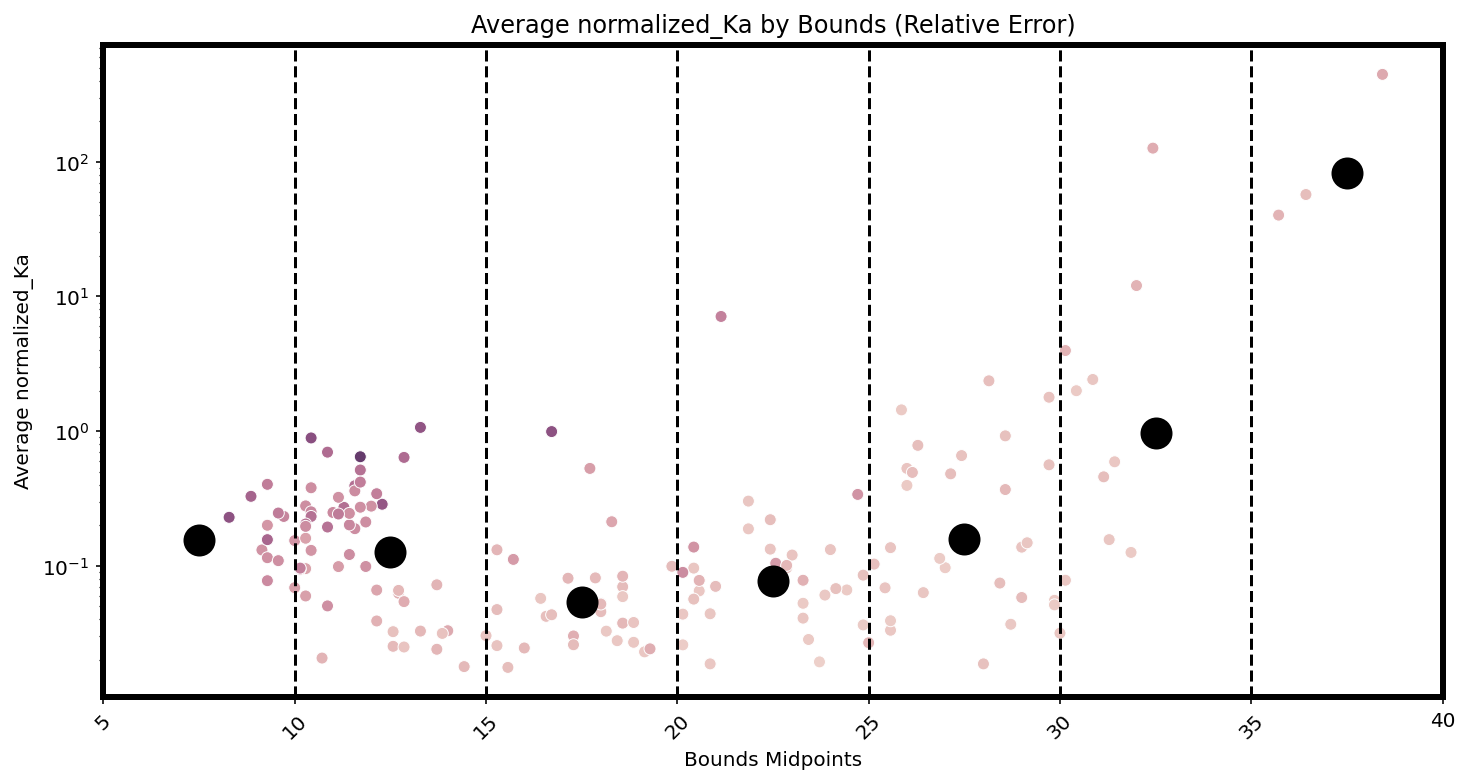

     Avg_Position           Mean   Bin  Comparison Final
300   9.571428571    0.109093212   7.5         1.0     A
200   9.571428571    0.246318823   7.5         1.0     A
125   9.714285714    0.232390531   7.5         1.0     A
315   9.285714286    0.156245127   7.5         1.0     A
185   9.285714286    0.402480177   7.5         1.0     A
..            ...            ...   ...         ...   ...
105  31.857142857    0.125573976  32.5         6.0     F
425  30.142857143    3.965329270  32.5         6.0     F
800  38.428571429  445.877866322  37.5         7.0     G
565  36.428571429   57.134463326  37.5         7.0     G
10   35.714285714   40.180814657  37.5         7.0     G

[172 rows x 5 columns]


In [26]:
#plot with hue of IWD

# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Calculate the mean of 'Ka' in 'wt_df'
wt_mean_Ka = wt_df['Ka'].mean()

# Convert 'Bin' column to numeric type, ignoring any non-numeric values
merged_df['Replicate'] = pd.to_numeric(merged_df['Replicate'], errors='coerce')

# Select rows where the value in the 'Bin' column is less than 172 or equal to 'NTD'
selected_rows = merged_df[(merged_df['Replicate'] < 172) | (merged_df['Replicate'] == 'WT')]

# Print the selected rows
#print(selected_rows)

# Normalize the 'Ka' values in 'selected_rows' by dividing by 'wt_mean_Ka'
selected_rows['normalized_Ka'] = selected_rows['Ka'] / wt_mean_Ka

# Plot the second scatter plot using the filtered dataframe
sns.scatterplot(data=selected_rows, x=selected_rows.groupby('Replicate')['Avg_Position'].mean(), y=selected_rows.groupby('Replicate')['normalized_Ka'].mean(), hue =selected_rows.groupby('Replicate')['IWD+'].mean(),hue_norm=(0,2.5),  ax=ax)

# Filter the dataframe based on the condition
wt_df = selected_rows[selected_rows['Replicate'] == 'WT']

# Calculate the lowest and highest values of 'Avg_Position'
lowest_value = selected_rows['Avg_Position'].min()
highest_value = selected_rows['Avg_Position'].max()

# Define the bin boundaries
bin_boundaries = np.arange(0, 50, 5)

# Calculate the average value and relative error of normalized_Ka for every 3-value bin
geometric_mean_by_bounds = selected_rows.groupby(pd.cut(selected_rows['Avg_Position'], bins=bin_boundaries))['normalized_Ka'].apply(gmean)

relative_error_by_bounds = selected_rows.groupby(pd.cut(selected_rows['Avg_Position'], bins=bin_boundaries)).std()['normalized_Ka']

# Calculate the midpoints of the bins
bounds_midpoints = [(bin_boundary.left + bin_boundary.right) / 2 for bin_boundary in geometric_mean_by_bounds.index]

# Create an empty DataFrame to store the results
data = pd.DataFrame(columns=['Avg_Position', 'Mean', 'Bin'])

# Iterate over each row in the dataframe
for index, row in selected_rows.iterrows():
    # Check if the 'Avg_Position' value falls within any bin
    for i, boundary in enumerate(bin_boundaries):
        if boundary <= row['Avg_Position'] < boundary + 5:
            # Calculate the midpoint of the bin
            bin_midpoint = boundary + 2.5
            
            # Add a new row to the data DataFrame
            data = data.append({'Avg_Position': row['Avg_Position'],
                                'Mean': selected_rows.groupby('Replicate')['normalized_Ka'].mean()[row['Replicate']],
                                'Bin': bin_midpoint},
                               ignore_index=True)
            break

# Remove duplicate rows from the data DataFrame
data = data.drop_duplicates(subset=['Avg_Position', 'Mean', 'Bin'])

# Sort the data DataFrame by the "Bin" column
data = data.sort_values('Bin')

# Assign the "Comparison" column based on the values in the "Bin" column
data['Comparison'] = data['Bin'].rank(method='dense')

# Map the values in the "Comparison" column to alphabetical characters
data['Final'] = data['Comparison'].apply(lambda x: chr(ord('A') + int(x) - 1))

# Plot the average Ka values with symmetric error bars

plt.errorbar(bounds_midpoints, geometric_mean_by_bounds, fmt='o', color='black', markersize=15, capsize=4, capthick=1)
print(geometric_mean_by_bounds)
# Plot the boundaries as dashed black lines
for bin_boundary in bin_boundaries:
    plt.axvline(x=bin_boundary, color='black', linestyle='--')

#sns.scatterplot(data=wt_df, x=wt_df['Avg_Position'], y=wt_df['normalized_Ka'].mean(), color='red', ax=ax)

plt.xlabel('Bounds Midpoints')
plt.ylabel('Average normalized_Ka')
plt.title('Average normalized_Ka by Bounds (Relative Error)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yscale('log')
plt.xlim(5,40)

# Remove legend
ax.legend([], [], frameon=False)

# Save the figure
#fig.savefig('Analysis/Plots/Scramble_position_box_plot_binned_normalizedcolor.png', format='png', dpi = 800)

# Show the plot
plt.show()

# Print the DataFrame
print(data)


In [27]:
# Extract the relevant datasets for comparison
dataset_test = data[data['Comparison'] == 1]['Mean']
dataset_5 = data[data['Comparison'] == 5]['Mean']

# Perform the Mann-Whitney U test
p_value = stats.mannwhitneyu(dataset_test, dataset_5).pvalue

# Print the p-value
print(f"p-value: {p_value}")

p-value: 0.6937481238934825


In [28]:
# Extract the relevant datasets for comparison
dataset_test = data[data['Comparison'] == 2]['Mean']
dataset_5 = data[data['Comparison'] == 5]['Mean']

# Perform the Mann-Whitney U test
p_value = stats.mannwhitneyu(dataset_test, dataset_5).pvalue

# Print the p-value
print(f"p-value: {p_value}")

p-value: 0.4688067889125196


In [29]:
# Extract the relevant datasets for comparison
dataset_test = data[data['Comparison'] == 3]['Mean']
dataset_5 = data[data['Comparison'] == 5]['Mean']

# Perform the Mann-Whitney U test
p_value = stats.mannwhitneyu(dataset_test, dataset_5).pvalue

# Print the p-value
print(f"p-value: {p_value}")

p-value: 0.0005993821461745008


In [30]:
# Extract the relevant datasets for comparison
dataset_test = data[data['Comparison'] == 4]['Mean']
dataset_5 = data[data['Comparison'] == 5]['Mean']

# Perform the Mann-Whitney U test
p_value = stats.mannwhitneyu(dataset_test, dataset_5).pvalue

# Print the p-value
print(f"p-value: {p_value}")

p-value: 0.048689197966295686


In [31]:
# Extract the relevant datasets for comparison
dataset_test = data[data['Comparison'] == 6]['Mean']
dataset_5 = data[data['Comparison'] == 5]['Mean']

# Perform the Mann-Whitney U test
p_value = stats.mannwhitneyu(dataset_test, dataset_5).pvalue

# Print the p-value
print(f"p-value: {p_value}")

p-value: 0.03397907501683483


In [32]:
# Extract the relevant datasets for comparison
dataset_test = data[data['Comparison'] == 7]['Mean']
dataset_5 = data[data['Comparison'] == 5]['Mean']

# Perform the Mann-Whitney U test
p_value = stats.mannwhitneyu(dataset_test, dataset_5).pvalue

# Print the p-value
print(f"p-value: {p_value}")

p-value: 0.0004032258064516129
